# Test suite for a physics-informed Neural Network to predict the rest-eigen part from the eigen-eigen part, the rest-rest part and the eigenvalues

In [1]:
using LmaPredict, Flux, Statistics, ProgressMeter, Plots, Metal, BenchmarkTools

## Reading the data

In [2]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [3]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]
em_n = "VV"

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em=em_n, bc=false))
end

## Splitting data in training and test sets

In [4]:
NCNFG = length(cnfgarr)
train_size = 500
test_size = NCNFG - train_size

TSRC = "24"
TVALS = length(cnfgarr[1].data["rr"][TSRC]) - 1
if em_n == "PA"
    EIGVALS = 32
else 
    EIGVALS = 64
end

eigvals_data_train = Array{Float64}(undef, EIGVALS, train_size)
rr_data_train = Array{Float64}(undef, TVALS, train_size)
ee_data_train = Array{Float64}(undef, TVALS, train_size)
re_data_train = Array{Float64}(undef, TVALS, train_size)

eigvals_data_test = Array{Float64}(undef, EIGVALS, test_size)
rr_data_test = Array{Float64}(undef, TVALS, test_size)
ee_data_test = Array{Float64}(undef, TVALS, test_size)
re_data_test = Array{Float64}(undef, TVALS, test_size)

for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:train_size])
    eigvals_data_train[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_train[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_train[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_train[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[train_size+1:NCNFG])
    eigvals_data_test[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_test[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

## Defining training and test data

In [8]:
input_length = TVALS
output_length = TVALS
hidden_length = EIGVALS * TVALS

input_data_train_ee = Flux.normalize(ee_data_train)
input_data_train_ev = repeat(1 ./ sort(eigvals_data_train,dims=1),outer=TVALS)

input_train = (input_data_train_ee, input_data_train_ev)
target_train = re_data_train

input_data_test_ee = Flux.normalize(ee_data_test)
input_data_test_ev = repeat(1 ./ sort(eigvals_data_test,dims=1),outer=TVALS)

input_test = (input_data_test_ee, input_data_test_ev)
target_test = re_data_test;

## Defining the Network

In [9]:
weights = zeros(TVALS,TVALS*EIGVALS)
for i in 1:TVALS
    start = (i-1)*EIGVALS + 1
    stop = start + EIGVALS - 1
    weights[i,start:stop] = ones(EIGVALS)
end

In [10]:
model = PairwiseFusion(.*,
    Dense(input_length => hidden_length, identity),
    Dense(weights, false, identity)
) |> f64

PairwiseFusion(
  Base.Broadcast.BroadcastFunction(*),
  Dense(47 => 1504),                    # 72_192 parameters
  Dense(1504 => 47; bias=false),        # 70_688 parameters
)                   # Total: 3 arrays, 142_880 parameters, 1.090 MiB.

### Defining loader, optimizer and loss function

In [11]:
loader = Flux.DataLoader((input_train, target_train), batchsize=64, shuffle=true)

optim = Flux.setup(Flux.Adam(0.01), model)
Flux.freeze!(optim.layers[2])

function loss(flux_model, x, y)
    ŷ = flux_model(x)
    Flux.mse(ŷ, y, agg=sum)
end

loss (generic function with 1 method)

## Training the Networkepochs = 10_000

In [13]:
epochs = 10_000

losses = []
@showprogress for epoch in 1:epochs
    for (x, y) in loader
        grads = gradient(m -> loss(m, x, y), model)
        Flux.update!(optim, model, grads[1])
        push!(losses,loss(model, x, y))
    end
end

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 2 and 47

## Checking loss dynamics during training

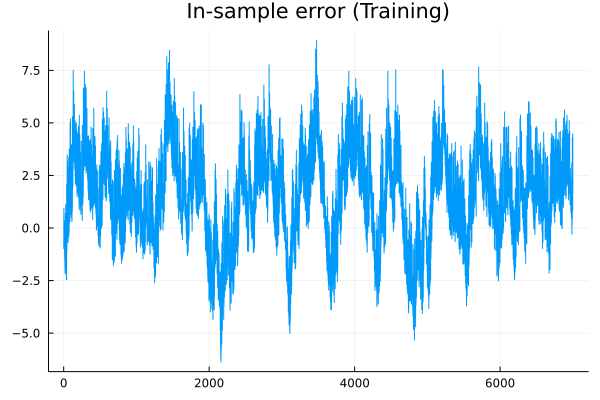

In [276]:
plot(log.(losses[end-7000:end] .- minimum(losses)), title="In-sample error (Training)", legend=:false)

## Checking out-of-sample results

maximum error: 21.632938591854437
minimum error: 0.3429921325117621
average error: 1.1044120771734645


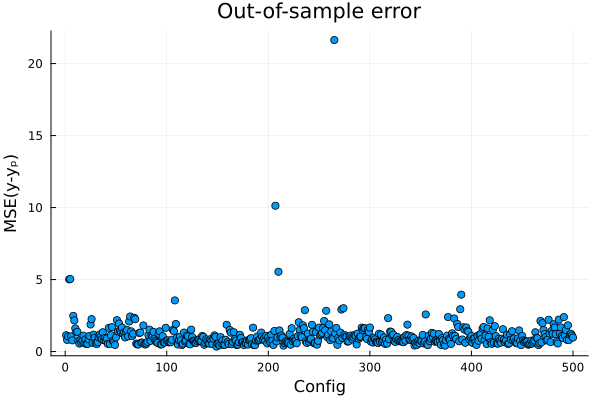

In [271]:
out_of_sample_predictions = model(input_test)[2]
out_of_sample_error = [Flux.mse(out_of_sample_predictions[:,i], target_test[:,i]) for i in 1:train_size]

println("maximum error: ", maximum(out_of_sample_error))
println("minimum error: ", minimum(out_of_sample_error))
println("average error: ", mean(out_of_sample_error))

scatter(out_of_sample_error, title="Out-of-sample error", legend=:false)
xlabel!("Config")
ylabel!("MSE(y-yₚ)")

In [261]:
l = @layout [a b c; d e f; g h i]

c1 = rand([i for i in 1:500])
p1 = scatter(target_test[:,c1], label="Actual")
scatter!(p1, out_of_sample_predictions[:,c1], label="Prediction", legend=:top)

c2 = rand([i for i in 1:500])
p2 = scatter(target_test[:,c2], label="Actual")
scatter!(p2, out_of_sample_predictions[:,c2], label="Prediction", legend=:top)

c3 = rand([i for i in 1:500])
p3 = scatter(target_test[:,c3], label="Actual")
scatter!(p3, out_of_sample_predictions[:,c3], label="Prediction", legend=:top, )

c4 = rand([i for i in 1:500])
p4 = scatter(target_test[:,c4], label="Actual")
scatter!(p4, out_of_sample_predictions[:,c4], label="Prediction", legend=:top)

c5 = rand([i for i in 1:500])
p5 = scatter(target_test[:,c5], label="Actual")
scatter!(p5, out_of_sample_predictions[:,c5], label="Prediction", legend=:top)

c6 = rand([i for i in 1:500])
p6 = scatter(target_test[:,c6], label="Actual")
scatter!(p6, out_of_sample_predictions[:,c6], label="Prediction", legend=:top)

c7 = rand([i for i in 1:500])
p7 = scatter(target_test[:,c7], label="Actual")
scatter!(p7, out_of_sample_predictions[:,c7], label="Prediction", legend=:top)

c8 = rand([i for i in 1:500])
p8 = scatter(target_test[:,c8], label="Actual")
scatter!(p8, out_of_sample_predictions[:,c8], label="Prediction", legend=:top)

c9 = rand([i for i in 1:500])
p9 = scatter(target_test[:,c9], label="Actual")
scatter!(p9, out_of_sample_predictions[:,c9], label="Prediction", legend=:top)

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout = l, size=(1200,1000), dpi=1000, markerstrokewidth = 0)
#savefig(joinpath(path_plot, "neural_network_test.pdf"))

# Bias correction

### Applying bias correction on a percentage of the test data

In [ ]:
percentage = 0.1

n_configs = Int(test_size * percentage)

configs = sort!(sample([i for i in 1:test_size], n_configs, replace = false))

uncorr_target_configs = stack(deleteat!([output_shape_test[:,i] for i in 1:test_size],configs), dims=2)

mean_target = mean.([uncorr_target_configs[i,:] for i in 1:TVALS])
σ_mean_target = std.([uncorr_target_configs[i,:] for i in 1:TVALS]) ./ sqrt(test_size - 1 - n_configs)
    
mean_predicted = mean.([out_of_sample_predictions[i,:] for i in 1:TVALS])
σ_predicted = std.([out_of_sample_predictions[i,:] for i in 1:TVALS]) ./ sqrt(test_size - 1 - n_configs)
        
bias_correction = mean(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2)
σ_bc = std(hcat([[out_of_sample_predictions[:,i] - output_shape_test[:,i] for i in configs][i] for i in 1:length(configs)]...), dims=2) ./ sqrt(n_configs - 1)

mean_predicted = mean_predicted - bias_correction
σ_pred_bc = σ_predicted + σ_bc

mean_diff = (mean_target .- mean_predicted) ./ mean_target
σ_diff = sqrt.(sum.(hcat([((mean_target .- out_of_sample_predictions[:,i] - bias_correction) ./ mean_target).^2 for i in 1:test_size]...)[k,:] for k in 1:TVALS) ./ (test_size - 1));

In [ ]:
using Plots

p = plot(size=(1000,800),thickness_scaling = 1.6)
scatter!(p,re_mean,
    yerr=re_err,
    label="actual",
    legend=:top,
    line=(:dot, 1),
    linecolor=:blue,
    markerstrokewidth = 0.1,
    markersize = 5,
    markeralpha = 0.6
)
scatter!(p,re_predicted_mean_corrected,
    yerr=re_predicted_err,
    label="predicted",
    marker = ([:hex :d]),
    line = (:dot, 1),
    linecolor=:red,
    markerstrokewidth = 0.1,
    markersize = 5,
    markeralpha = 0.6
)
xlabel!(p,"t")
ylabel!(p,"rest-eigen")